# Rovnice mělké vody

## Případ s rovným dnem v 1D

Předpoklady:
 - konstantní šířka kanálu $L$,
 - konstantní hustota $\rho$,
 - rychlost $u$ závisí pouze na $x$ a $t$ (je tedy v celém průřezu stejná),
 - výška hladiny $h$ nad dnem ($z=0$) závisí pouze na $x$ a $t$ (je tedy po celé šířce kanálu stejná),
 - pohyb je bez tření,
 - konstantní tíhové zrychlení $g$
 
Hmotnost tekutiny mezi $x_1$ a $x_2$:
$$
    m_{12}(t) = \int_{x_1}^{x_2} \rho L h(x,t) \, dx,
$$

Bilance hmoty (změna hmotnosti = přítok - odtok):
$$
    \dot{m}_{12}(t) = \rho L h(x_1,t) u(x_1,t) - \rho L h(x_2,t) u(x_2,t)
$$
neboli v diferenciálním tvaru
$$
    \frac{\partial h}{\partial t} + \frac{\partial (hu)}{\partial x} = 0.
$$

Hybnost tekutiny mezi $x_1$ a $x_2$:
$$
    i_{12}(t) = \int_{x_1}^{x_2} \rho L h(x,t) u(x,t) \, dx,
$$

Hydrostatická síla působicí v bodě $x$
$$
    F_h(x,t) = \int_{0}^{h(x,t)} \rho L g z \,dz = \frac{1}{2} \rho L g h^{2}(x,t)
$$

Bilance hybnosti(změna hybnosti = přítok - odtok + rozdíl hydrostatických sil):
$$
    \dot{i}_{12}(t) = \rho L h(x_1,t) u(x_1,t)^2 - \rho L h(x_2,t) u(x_2,t)^2 
    + \frac{1}{2} \rho L g h^{2}(x_1,t) - \frac{1}{2} \rho L g h^{2}(x_2,t)
$$
neboli v diferenciálním tvaru
$$
    \frac{\partial (hu)}{\partial t} + \frac{\partial (hu^2+gh^2/2)}{\partial x} = 0.
$$


### Rovnice popisující proudění mělké vody v 1D
\begin{align*}
    \frac{\partial h}{\partial t} + \frac{\partial (hu)}{\partial x} &= 0, \\
    \frac{\partial (hu)}{\partial t} + \frac{\partial (hu^2+gh^2/2)}{\partial x} &= 0.
\end{align*}


In [1]:
using SymPy

In [2]:
h, q, u, g = symbols("h q u g")

(h, q, u, g)

In [3]:
W=[h;q]

2-element Array{Sym,1}:
 h
 q

In [4]:
F=[q;q^2/h + g*h^2/2]

2-element Array{Sym,1}:
               q
 g*h^2/2 + q^2/h

In [5]:
A=[diff(F[1],h) diff(F[1],q); diff(F[2],h) diff(F[2],q)]

2×2 Array{Sym,2}:
             0      1
 g*h - q^2/h^2  2*q/h

In [6]:
A=subs.(A,q,h*u)

2×2 Array{Sym,2}:
         0    1
 g*h - u^2  2*u

In [7]:
eig=A.eigenvects()

2-element Array{Tuple{Sym,Int64,Array{Array{Sym,2},1}},1}:
 (u - sqrt(g*h), 1, [[-1/(-u + sqrt(g*h)); 1]])
 (u + sqrt(g*h), 1, [[-1/(-u - sqrt(g*h)); 1]])

In [8]:
r1=eig[1][3][1]
r1

2×1 Array{Sym,2}:
 -1/(-u + sqrt(g*h))
                   1

In [9]:
r2=eig[2][3][1]
r2

2×1 Array{Sym,2}:
 -1/(-u - sqrt(g*h))
                   1

**Věta** Systém rovnic popisující pohyb mělké vody je hyperbolický právě tehdy, když $h>0$.

## Simulace problému protržení hráze

Uvažujeme počáteční problém popsaný rovnicemi pro pohyb mělké vody v 1D. Jako počáteční podmínku uvažujeme stav s nulovou rychlostí ($u=0$) a s hladinou o výšce
$$
    h(x,0) = \left\{
    \begin{array}{ll}
        1 & \text{pro } x < 0.5, \\
        0.01 & \text{pro } x \ge 0.5.
    \end{array}
    \right.
$$

In [10]:
using Plots
pyplot()

Plots.PyPlotBackend()

In [11]:
n = 200
dx = 1.0 / n
x = range(dx/2,stop=1-dx/2, length=n);

In [12]:
# Initial condition
u =  [ 0.0 for xi in x ]
h = [ (xi<0.5 ? 1.1 : 0.01) for xi in x]
g = 10.0;

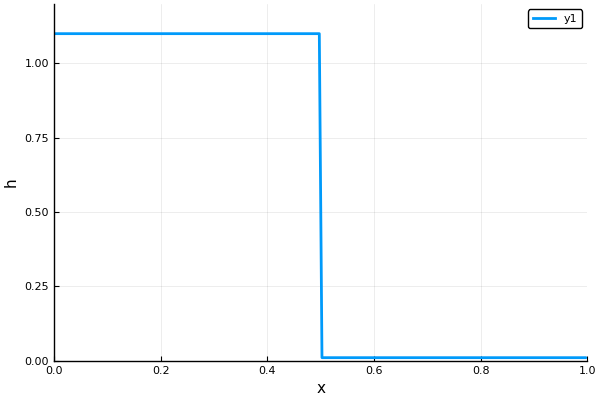

In [13]:
plot(x, h, lw=2, grid=true);
xlims!((0,1)); ylims!((0,1.2));
xlabel!("x");   ylabel!("h")

In [14]:
const H_ = 1
const HU_ = 2

function eigen(W)
    h  = W[H_]
    hu = W[HU_]
    u  = hu / h
    a  = sqrt(g*h)
    return [u - a, u + a]
end;

function sigma(W)
    eig = eigen(W)
    return max(abs(eig[1]),abs(eig[2]))
end;

function flux(W)
    h  = W[H_]
    hu = W[HU_]
    u  = hu / h
    return [ hu; hu*u + 0.5*g*h^2]
end;

function HLL(Wl, Wr)
    Fl = flux(Wl)
    Fr = flux(Wr)
    
    eigl = eigen(Wl)
    eigr = eigen(Wr)
    sl = min(eigl[1], eigr[1])
    sr = max(eigl[2], eigr[2])
    
    if 0.0 <= sl
        return Fl
    elseif 0.0 < sr
        return (sr*Fl - sl*Fr + sl*sr*(Wr-Wl)) / (sr - sl)
    else
        return Fr
    end
end;

In [15]:
W = [h h.*u]'

2×200 LinearAlgebra.Adjoint{Float64,Array{Float64,2}}:
 1.1  1.1  1.1  1.1  1.1  1.1  1.1  …  0.01  0.01  0.01  0.01  0.01  0.01
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0   0.0   0.0   0.0   0.0   0.0 

In [16]:
sigma(W[:,1])

3.3166247903554

In [17]:
flux(W[:,1])

2-element Array{Float64,1}:
 0.0              
 6.050000000000001

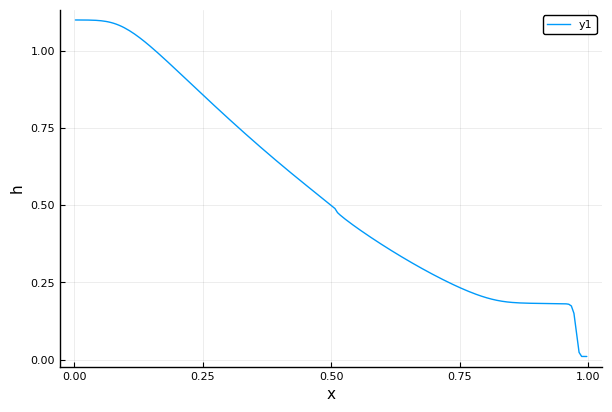

In [18]:
F = zeros(2,n+1)
W = [h h.*u]'

t = 0.0

anim = @animate for iter=1:150
    
    dt = 1.e16
    for i=1:n
        dt = min(dt, 0.8*dx/sigma(W[:,i]))
    end
    
    F[:,1] = HLL(W[:,1],W[:,1])
    F[:,end] = HLL(W[:,end],W[:,end])
    
    for i=1:n-1
        F[:,i+1] = HLL(W[:,i],W[:,i+1])
    end
    
    for i=1:n
        for k=1:2
            W[k,i] = W[k,i] - dt / dx * (F[k,i+1]-F[k,i])
        end
    end
    
    plot(x, W[H_,:], xlabel="x", ylabel="h")
end;

┌ Info: Saved animation to 
│   fn = /home/furst/Vyuka/MMPP/lessons/tmp.gif
└ @ Plots /home/furst/.julia/packages/Plots/WwFyB/src/animation.jl:98


Plots.AnimatedGif("/home/furst/Vyuka/MMPP/lessons/tmp.gif")
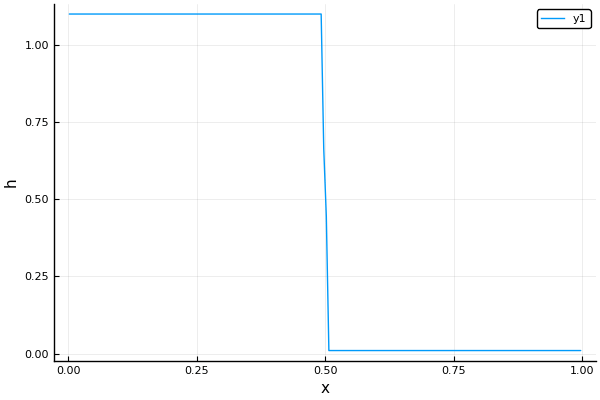

In [19]:
gif(anim)

## Případ se zadaným tvarem dna

Tvar dna je dán funkcí $b(x)$. Veličina $h$ je výška hladiny nad dnem. Pohyb mělké vody je pak popsán rovnicemi
\begin{align*}
    \frac{\partial h}{\partial t} + \frac{\partial (hu)}{\partial x} &= 0, \\
    \frac{\partial (hu)}{\partial t} + \frac{\partial (hu^2+gh^2/2)}{\partial x} &= -g h b'(x).
\end{align*}


In [20]:
function bottom(xi)
    z = ( (0.3<xi && xi<0.7) ? (cos(pi*(xi-0.5)/0.2)+1)/2 : 0.0)
    z = z + 0.2*(1-xi)
    return z
end

b = [bottom(xi) for xi in x ];
bx = [(bottom(xi+dx/2)-bottom(xi-dx/2))/dx for xi in x ];


In [21]:
q_in = 0.5;
h_out = 0.8;

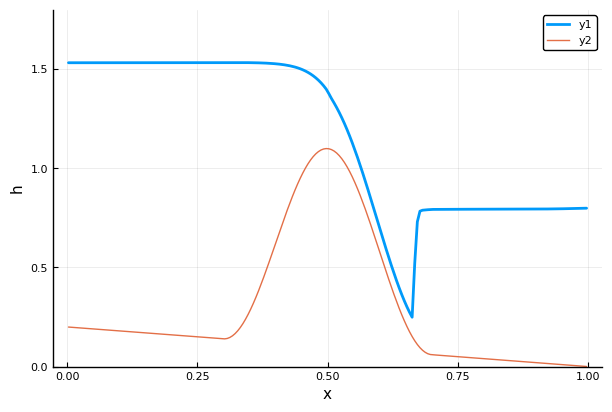

In [22]:
h = max.(h_out.-b, 0.01)
W = [h h.*u]'

anim2 = @animate for iter=1:2000

    dt = 1.e16
    for i=1:n
        dt = min(dt, 0.8 * dx / sigma(W[:,i]))
    end
    
    F[:,1]   = HLL([W[H_,1], q_in], W[:,1])
    F[:,end] = HLL(W[:,end], [h_out; W[HU_,end]])
    
    for i=1:n-1
        F[:,i+1] = HLL(W[:,i],W[:,i+1])
    end
    
    for i=1:n
        Q = [0.0; -g * W[H_,i] * bx[i] ]
        for k=1:2
            W[k,i] = W[k,i] - dt / dx * (F[k,i+1]-F[k,i]) + dt * Q[k]
        end
    end
    
    plot(x, W[H_,:]+b, lw=2, ylim=(0,1.8), xlabel="x", ylabel="h")
    plot!(x, b)
end every 10;

┌ Info: Saved animation to 
│   fn = /home/furst/Vyuka/MMPP/lessons/tmp.gif
└ @ Plots /home/furst/.julia/packages/Plots/WwFyB/src/animation.jl:98


Plots.AnimatedGif("/home/furst/Vyuka/MMPP/lessons/tmp.gif")
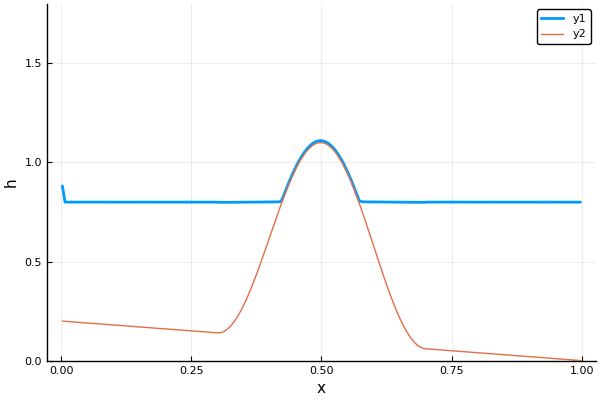

In [23]:
gif(anim2)